# LASSO Signal IC Comparison

Compare the information coefficient (IC) of the LASSO-augmented signal vs the futures-only baseline signal
for predicting hedged ADR returns (long ADR, short market ETF) from various entry times to 16:00 NBBO mid.

Signals clipped to [-0.01, 0.01].

**Only dates where the LASSO model was fit are included** — identified as dates where the LASSO signal
differs from the baseline signal. Only LASSO-eligible tickers are compared.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import spearmanr
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

DATA_DIR = Path('..') / 'data'
ENTRY_TIMES = ['13:00', '13:30', '14:00', '14:30', '15:00', '15:30']
CLOSE_TIME = '16:00'

## Load metadata

In [2]:
# Load ADR info for ticker -> market ETF mapping
adr_info = pd.read_csv(DATA_DIR / 'raw' / 'adr_info.csv')
adr_info['ticker'] = adr_info['adr'].str.replace(' US Equity', '')
ticker_to_etf = dict(zip(adr_info['ticker'], adr_info['market_etf_hedge']))

# All tickers
all_tickers = sorted(adr_info['ticker'].tolist())
print(f'{len(all_tickers)} ADR tickers')
print(f'Market ETF mapping: {dict(pd.Series(ticker_to_etf).value_counts())}')

54 ADR tickers
Market ETF mapping: {'FEZ': 23, 'EWU': 22, 'EWJ': 7, 'EWA': 2}


In [3]:
# Load hedge ratios
hedge_ratios = pd.read_csv(
    DATA_DIR / 'processed' / 'market_etf_hedge_ratios.csv',
    index_col=0, parse_dates=True
)
print(f'Hedge ratios: {hedge_ratios.shape}')
hedge_ratios.head()

Hedge ratios: (1862, 54)


,AEG,ARGX,ASML,AZN,BBVA,BCS,BHP,BP,BTI,BUD,...,SONY,TAK,TM,TS,TTE,UBS,UL,VOD,WDS,WPP
2018-09-04,0.817788,0.398688,1.276835,0.245103,1.324642,1.103495,1.320763,1.110719,0.845800,0.720068,...,1.190215,0.829546,0.973991,1.100483,0.533227,0.873175,0.739255,0.966030,0.993917,0.915226
2018-09-05,0.806686,0.399403,1.286204,0.245571,1.312370,1.091303,1.312595,1.107619,0.848750,0.722844,...,1.186817,0.829236,0.979885,1.104809,0.552886,0.867906,0.745644,0.974381,0.995156,0.955830
2018-09-06,0.803712,0.392895,1.290553,0.238796,1.310233,1.090294,1.312215,1.110170,0.851269,0.721044,...,1.185260,0.837750,0.981047,1.109705,0.552767,0.861389,0.745844,0.974066,0.988835,0.963161
2018-09-07,0.804219,0.399329,1.301599,0.210487,1.316119,1.088299,1.313011,1.115269,0.859024,0.728488,...,1.185392,0.834213,0.979632,1.113689,0.553769,0.860835,0.750060,0.972089,0.989028,0.962739
2018-09-10,0.807189,0.396369,1.306075,0.211555,1.313879,1.089253,1.312640,1.114557,0.851172,0.728880,...,1.183882,0.834200,0.979870,1.119715,0.551632,0.864319,0.746411,0.969548,1.000443,0.955130


## Load NBBO data and compute mid prices at entry/close times

In [4]:
def load_nbbo_mid(path):
    """Load NBBO parquet and return mid prices as a Series."""
    df = pd.read_parquet(path, columns=['nbbo_bid', 'nbbo_ask'])
    mid = (df['nbbo_bid'] + df['nbbo_ask']) / 2
    return mid


def extract_prices_at_times(mid_series, times):
    """
    For each trading date, extract mid price at each requested time.
    Returns DataFrame with date index and time columns.
    """
    # Get unique dates
    dates = mid_series.index.normalize().unique()
    
    results = {}
    for t in times:
        h, m = map(int, t.split(':'))
        # Build target timestamps for all dates
        targets = pd.DatetimeIndex([
            d.replace(hour=h, minute=m) for d in dates
        ])
        # Use reindex with ffill to get closest price at or before target
        prices = mid_series.reindex(targets, method='ffill')
        results[t] = prices.values
    
    return pd.DataFrame(results, index=dates.date)

In [5]:
all_times = ENTRY_TIMES + [CLOSE_TIME]

# Load ADR mid prices at entry and close times
adr_prices = {}  # ticker -> DataFrame(date x times)
print('Loading ADR NBBO data...')
for ticker in tqdm(all_tickers):
    path = DATA_DIR / 'raw' / 'adrs' / 'bbo-1m' / 'nbbo' / f'ticker={ticker}' / 'data.parquet'
    if not path.exists():
        continue
    mid = load_nbbo_mid(path)
    adr_prices[ticker] = extract_prices_at_times(mid, all_times)

print(f'Loaded ADR prices for {len(adr_prices)} tickers')

Loading ADR NBBO data...


  0%|          | 0/54 [00:00<?, ?it/s]

Loaded ADR prices for 54 tickers


In [6]:
# Load ETF mid prices at entry and close times
etf_prices = {}  # etf -> DataFrame(date x times)
unique_etfs = set(ticker_to_etf.values())
print(f'Loading ETF NBBO data for: {unique_etfs}')
for etf in unique_etfs:
    path = DATA_DIR / 'raw' / 'etfs' / 'market' / 'bbo-1m' / 'nbbo' / f'ticker={etf}' / 'data.parquet'
    if not path.exists():
        print(f'  WARNING: {path} not found')
        continue
    mid = load_nbbo_mid(path)
    etf_prices[etf] = extract_prices_at_times(mid, all_times)
    print(f'  {etf}: {etf_prices[etf].shape}')

print(f'Loaded ETF prices for {len(etf_prices)} ETFs')

Loading ETF NBBO data for: {'EWJ', 'EWA', 'FEZ', 'EWU'}


  EWJ: (1949, 7)


  EWA: (1949, 7)


  FEZ: (1949, 7)


  EWU: (1949, 7)
Loaded ETF prices for 4 ETFs


## Compute actual hedged returns from entry to 16:00 NBBO mid

In [7]:
# For each ticker and entry time, compute:
#   hedged_return = adr_return(entry->close) - hedge_ratio * etf_return(entry->close)
# Using NBBO mid at 16:00 as exit price

hedged_returns = {}  # (ticker, entry_time) -> Series indexed by date

for ticker in all_tickers:
    if ticker not in adr_prices:
        continue
    etf = ticker_to_etf.get(ticker)
    if etf not in etf_prices:
        continue
    
    adr_px = adr_prices[ticker]
    etf_px = etf_prices[etf]
    
    # Get hedge ratios for this ticker
    if ticker not in hedge_ratios.columns:
        continue
    hr = hedge_ratios[ticker]
    
    # Align dates
    common_dates = adr_px.index.intersection(etf_px.index)
    
    for entry_time in ENTRY_TIMES:
        adr_entry = adr_px.loc[common_dates, entry_time]
        adr_close = adr_px.loc[common_dates, CLOSE_TIME]
        etf_entry = etf_px.loc[common_dates, entry_time]
        etf_close = etf_px.loc[common_dates, CLOSE_TIME]
        
        adr_ret = (adr_close - adr_entry) / adr_entry
        etf_ret = (etf_close - etf_entry) / etf_entry
        
        # Align hedge ratio by date
        hr_aligned = hr.reindex(pd.DatetimeIndex(common_dates)).values
        
        hedged_ret = adr_ret.values - hr_aligned * etf_ret.values
        hedged_returns[(ticker, entry_time)] = pd.Series(
            hedged_ret, index=common_dates, name=ticker
        )

print(f'Computed hedged returns for {len(hedged_returns)} (ticker, time) pairs')

Computed hedged returns for 324 (ticker, time) pairs


## Load signals at entry times

In [8]:
def load_signal_at_times(signal_dir, tickers, entry_times, clip=0.01):
    """
    Load signal values at each entry time for each ticker.
    Clips signals to [-clip, clip] to match existing analysis.
    Returns dict: (ticker, entry_time) -> Series indexed by date.
    """
    signals = {}
    for ticker in tqdm(tickers):
        path = signal_dir / f'ticker={ticker}' / 'data.parquet'
        if not path.exists():
            continue
        df = pd.read_parquet(path)
        
        for entry_time in entry_times:
            h, m = map(int, entry_time.split(':'))
            # Filter to the specific minute
            mask = (df.index.hour == h) & (df.index.minute == m)
            sig_at_time = df.loc[mask, 'signal'].clip(-clip, clip)
            if len(sig_at_time) == 0:
                continue
            # Index by date
            sig_at_time.index = sig_at_time.index.date
            signals[(ticker, entry_time)] = sig_at_time
    
    return signals


print('Loading LASSO signals...')
lasso_signals = load_signal_at_times(
    DATA_DIR / 'processed' / 'index_russell_lasso_signal',
    all_tickers, ENTRY_TIMES
)
print(f'  {len(lasso_signals)} (ticker, time) pairs')

print('Loading baseline signals...')
baseline_signals = load_signal_at_times(
    DATA_DIR / 'processed' / 'futures_only_signal',
    all_tickers, ENTRY_TIMES
)
print(f'  {len(baseline_signals)} (ticker, time) pairs')

Loading LASSO signals...


  0%|          | 0/54 [00:00<?, ?it/s]

  324 (ticker, time) pairs
Loading baseline signals...


  0%|          | 0/54 [00:00<?, ?it/s]

  324 (ticker, time) pairs


## Identify LASSO-active dates and filter

For each LASSO-eligible ticker and entry time, find dates where the LASSO signal differs
from the baseline (i.e., where the LASSO model was actually applied, not falling back to baseline).

In [9]:
LASSO_ELIGIBLE = [
    'ARGX', 'ASML', 'AZN', 'BP', 'BTI', 'BUD', 'DEO', 'E', 'EQNR',
    'FMS', 'GMAB', 'GSK', 'HLN', 'IHG', 'NGG', 'NVS', 'RIO',
    'SHEL', 'SNY', 'TS', 'TTE', 'UL'
]

# For each (ticker, entry_time), find dates where the LASSO model was fit
# (i.e., where lasso signal != baseline signal)
lasso_active_dates = {}  # (ticker, entry_time) -> set of dates

for ticker in LASSO_ELIGIBLE:
    for entry_time in ENTRY_TIMES:
        key = (ticker, entry_time)
        if key not in lasso_signals or key not in baseline_signals:
            continue
        lasso_sig = lasso_signals[key]
        base_sig = baseline_signals[key]
        common = lasso_sig.index.intersection(base_sig.index)
        l = lasso_sig.loc[common]
        b = base_sig.loc[common]
        # Dates where signals differ (LASSO model was applied)
        differs = l.values != b.values
        active_dates = set(common[differs])
        lasso_active_dates[key] = active_dates

# Summary
total_pairs = 0
total_active = 0
for key, dates in lasso_active_dates.items():
    total_pairs += 1
    total_active += len(dates)
print(f'{total_pairs} (ticker, time) pairs with LASSO-active dates')
print(f'{total_active} total LASSO-active (ticker, time, date) observations')
if total_pairs > 0:
    print(f'Mean {total_active / total_pairs:.0f} active dates per (ticker, time) pair')

# Show per-ticker active date counts at 14:30
print(f'\nLASSO-active dates per ticker at 14:30:')
for ticker in LASSO_ELIGIBLE:
    key = (ticker, '14:30')
    n = len(lasso_active_dates.get(key, set()))
    print(f'  {ticker}: {n}')

132 (ticker, time) pairs with LASSO-active dates
15566 total LASSO-active (ticker, time, date) observations
Mean 118 active dates per (ticker, time) pair

LASSO-active dates per ticker at 14:30:
  ARGX: 201
  ASML: 224
  AZN: 0
  BP: 0
  BTI: 0
  BUD: 211
  DEO: 0
  E: 230
  EQNR: 219
  FMS: 221
  GMAB: 203
  GSK: 0
  HLN: 184
  IHG: 0
  NGG: 0
  NVS: 221
  RIO: 0
  SHEL: 0
  SNY: 226
  TS: 216
  TTE: 226
  UL: 0


In [10]:
def compute_ic_filtered(signals, hedged_returns, entry_times, tickers,
                        date_filter=None, min_obs=30):
    """
    Compute IC (Pearson correlation) between signal and hedged return.
    
    Args:
        date_filter: dict of (ticker, entry_time) -> set of dates to include.
                     If None, use all dates.
    
    Returns:
        per_ticker_ic: DataFrame (tickers x entry_times) of per-ticker ICs
        per_ticker_n: DataFrame (tickers x entry_times) of observation counts
        pooled_ic: Series indexed by entry_time of pooled ICs
        cross_sectional_ic: Series indexed by entry_time of mean cross-sectional ICs
    """
    per_ticker_ic = pd.DataFrame(index=tickers, columns=entry_times, dtype=float)
    per_ticker_n = pd.DataFrame(index=tickers, columns=entry_times, dtype=float)
    pooled_data = {t: {'signal': [], 'actual': []} for t in entry_times}
    cs_ic_by_date = {t: {} for t in entry_times}
    
    for ticker in tickers:
        for entry_time in entry_times:
            key = (ticker, entry_time)
            if key not in signals or key not in hedged_returns:
                continue
            
            sig = signals[key]
            ret = hedged_returns[key]
            
            # Align
            common = sig.index.intersection(ret.index)
            
            # Apply date filter
            if date_filter is not None and key in date_filter:
                common = common.intersection(pd.Index(list(date_filter[key])))
            
            if len(common) < min_obs:
                continue
            
            s = sig.loc[common].values
            r = ret.loc[common].values
            
            # Drop NaN/inf pairs
            valid = ~(np.isnan(s) | np.isnan(r) | np.isinf(s) | np.isinf(r))
            s, r = s[valid], r[valid]
            common_valid = np.array(common)[valid]
            
            if len(s) < min_obs:
                continue
            
            # Per-ticker IC (Pearson)
            corr = np.corrcoef(s, r)[0, 1]
            per_ticker_ic.loc[ticker, entry_time] = corr
            per_ticker_n.loc[ticker, entry_time] = len(s)
            
            # Collect for pooled
            pooled_data[entry_time]['signal'].extend(s.tolist())
            pooled_data[entry_time]['actual'].extend(r.tolist())
            
            # Collect for cross-sectional
            for date, sv, rv in zip(common_valid, s, r):
                if date not in cs_ic_by_date[entry_time]:
                    cs_ic_by_date[entry_time][date] = []
                cs_ic_by_date[entry_time][date].append((sv, rv))
    
    # Pooled IC
    pooled_ic = pd.Series(index=entry_times, dtype=float, name='pooled_ic')
    pooled_n = pd.Series(index=entry_times, dtype=int, name='pooled_n')
    for t in entry_times:
        s = np.array(pooled_data[t]['signal'])
        r = np.array(pooled_data[t]['actual'])
        pooled_n[t] = len(s)
        if len(s) > min_obs:
            pooled_ic[t] = np.corrcoef(s, r)[0, 1]
    
    # Cross-sectional IC (mean daily IC)
    cs_ic = pd.Series(index=entry_times, dtype=float, name='cross_sectional_ic')
    cs_ic_std = pd.Series(index=entry_times, dtype=float, name='cs_ic_std')
    cs_n_days = pd.Series(index=entry_times, dtype=int, name='n_days')
    min_tickers_per_date = 5
    for t in entry_times:
        daily_ics = []
        for date, pairs in cs_ic_by_date[t].items():
            if len(pairs) < min_tickers_per_date:
                continue
            sigs, rets = zip(*pairs)
            corr = np.corrcoef(sigs, rets)[0, 1]
            if not np.isnan(corr):
                daily_ics.append(corr)
        if daily_ics:
            cs_ic[t] = np.mean(daily_ics)
            cs_ic_std[t] = np.std(daily_ics) / np.sqrt(len(daily_ics))
            cs_n_days[t] = len(daily_ics)
    
    return per_ticker_ic, per_ticker_n, pooled_ic, pooled_n, cs_ic, cs_ic_std, cs_n_days

## Compute IC on LASSO-active dates only

Both signals are evaluated on the **same dates** — only those where the LASSO model was fit.
This gives a fair apples-to-apples comparison.

In [11]:
print('Computing ICs for LASSO signal (LASSO-active dates only)...')
lasso_per_ticker, lasso_per_n, lasso_pooled, lasso_pooled_n, lasso_cs, lasso_cs_std, lasso_cs_ndays = \
    compute_ic_filtered(lasso_signals, hedged_returns, ENTRY_TIMES, LASSO_ELIGIBLE,
                        date_filter=lasso_active_dates)

print('Computing ICs for baseline signal (same LASSO-active dates)...')
base_per_ticker, base_per_n, base_pooled, base_pooled_n, base_cs, base_cs_std, base_cs_ndays = \
    compute_ic_filtered(baseline_signals, hedged_returns, ENTRY_TIMES, LASSO_ELIGIBLE,
                        date_filter=lasso_active_dates)

print(f'\nPooled obs per entry time: {dict(lasso_pooled_n)}')

Computing ICs for LASSO signal (LASSO-active dates only)...


Computing ICs for baseline signal (same LASSO-active dates)...


/home/pmalonis/miniconda3/envs/cef2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/pmalonis/miniconda3/envs/cef2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/pmalonis/miniconda3/envs/cef2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/pmalonis/miniconda3/envs/cef2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Pooled obs per entry time: {'13:00': 2455.0, '13:30': 2421.0, '14:00': 2390.0, '14:30': 2383.0, '15:00': 2371.0, '15:30': 2351.0}


## Results: Pooled IC comparison (LASSO-active dates only)

In [12]:
ic_comparison = pd.DataFrame({
    'LASSO': lasso_pooled,
    'Baseline': base_pooled,
    'Improvement': lasso_pooled - base_pooled,
    'N obs': lasso_pooled_n
})
ic_comparison.index.name = 'Entry Time'
print('Pooled IC (Pearson corr, signal vs hedged return to 16:00)')
print('LASSO-active dates only, LASSO-eligible tickers only')
print('=' * 65)
display(ic_comparison.round(4))

Pooled IC (Pearson corr, signal vs hedged return to 16:00)
LASSO-active dates only, LASSO-eligible tickers only


,LASSO,Baseline,Improvement,N obs
Entry Time,,,,
13:00,-0.0254,-0.0356,0.0103,2455.0
13:30,-0.0418,-0.0415,-0.0003,2421.0
14:00,-0.0118,-0.0169,0.0051,2390.0
14:30,0.0207,-0.0075,0.0283,2383.0
15:00,0.0181,-0.0222,0.0404,2371.0
15:30,0.0130,0.0018,0.0111,2351.0


## Results: Cross-sectional IC comparison (LASSO-active dates only)

In [13]:
cs_comparison = pd.DataFrame({
    'LASSO IC': lasso_cs,
    'LASSO SE': lasso_cs_std,
    'Baseline IC': base_cs,
    'Baseline SE': base_cs_std,
    'Improvement': lasso_cs - base_cs,
    'N days': lasso_cs_ndays
})
cs_comparison.index.name = 'Entry Time'
print('Cross-sectional IC (mean daily Pearson corr across tickers)')
print('LASSO-active dates only, LASSO-eligible tickers only')
print('=' * 65)
display(cs_comparison.round(4))

Cross-sectional IC (mean daily Pearson corr across tickers)
LASSO-active dates only, LASSO-eligible tickers only


,LASSO IC,LASSO SE,Baseline IC,Baseline SE,Improvement,N days
Entry Time,,,,,,
13:00,-0.0325,0.0244,-0.0379,0.0254,0.0054,232.0
13:30,-0.0324,0.0235,-0.0328,0.0250,0.0004,232.0
14:00,0.0095,0.0234,0.0073,0.0248,0.0022,231.0
14:30,0.0548,0.0244,0.0137,0.0261,0.0411,231.0
15:00,0.0486,0.0242,0.0180,0.0267,0.0306,232.0
15:30,0.0425,0.0248,0.0177,0.0266,0.0248,231.0


In [14]:
## Results: Per-ticker IC comparison (LASSO-active dates only)

In [15]:
# Per-ticker IC at 14:30 (the main entry time)
main_time = '14:30'
per_ticker_comparison = pd.DataFrame({
    'LASSO IC': lasso_per_ticker[main_time],
    'Baseline IC': base_per_ticker[main_time],
    'Improvement': lasso_per_ticker[main_time].astype(float) - base_per_ticker[main_time].astype(float),
    'N obs': lasso_per_n[main_time]
}).dropna().sort_values('Improvement', ascending=False)

print(f'Per-ticker IC at {main_time} entry (LASSO-active dates only)')
print('=' * 65)
display(per_ticker_comparison.round(4))

Per-ticker IC at 14:30 entry (LASSO-active dates only)


,LASSO IC,Baseline IC,Improvement,N obs
E,-0.0480,-0.2132,0.1652,230.0
ASML,0.1219,0.0524,0.0694,224.0
ARGX,-0.0476,-0.1045,0.0569,201.0
GMAB,-0.0205,-0.0737,0.0532,203.0
EQNR,-0.0285,-0.0663,0.0378,211.0
NVS,-0.0533,-0.0690,0.0157,221.0
BUD,0.0762,0.0795,-0.0033,211.0
FMS,0.1087,0.1244,-0.0157,214.0
TTE,0.0288,0.0616,-0.0329,226.0
SNY,0.0310,0.0726,-0.0415,226.0


In [16]:
# Mean per-ticker IC across all entry times
lasso_mean_ic = lasso_per_ticker.astype(float).mean()
base_mean_ic = base_per_ticker.astype(float).mean()

mean_comparison = pd.DataFrame({
    'LASSO': lasso_mean_ic,
    'Baseline': base_mean_ic,
    'Improvement': lasso_mean_ic - base_mean_ic
})
mean_comparison.index.name = 'Entry Time'
print('Mean per-ticker IC (across LASSO-eligible tickers, LASSO-active dates only)')
print('=' * 65)
display(mean_comparison.round(4))

Mean per-ticker IC (across LASSO-eligible tickers, LASSO-active dates only)


,LASSO,Baseline,Improvement
Entry Time,,,
13:00,-0.0159,-0.0229,0.0070
13:30,-0.0322,-0.0395,0.0073
14:00,-0.0097,-0.0178,0.0080
14:30,0.0222,-0.0010,0.0232
15:00,0.0229,-0.0124,0.0353
15:30,0.0216,0.0135,0.0081


## Visualization

In [17]:
lasso_per_ticker.loc['BP']

Entry Time
13:00   NaN
13:30   NaN
14:00   NaN
14:30   NaN
15:00   NaN
15:30   NaN
Name: BP, dtype: float64

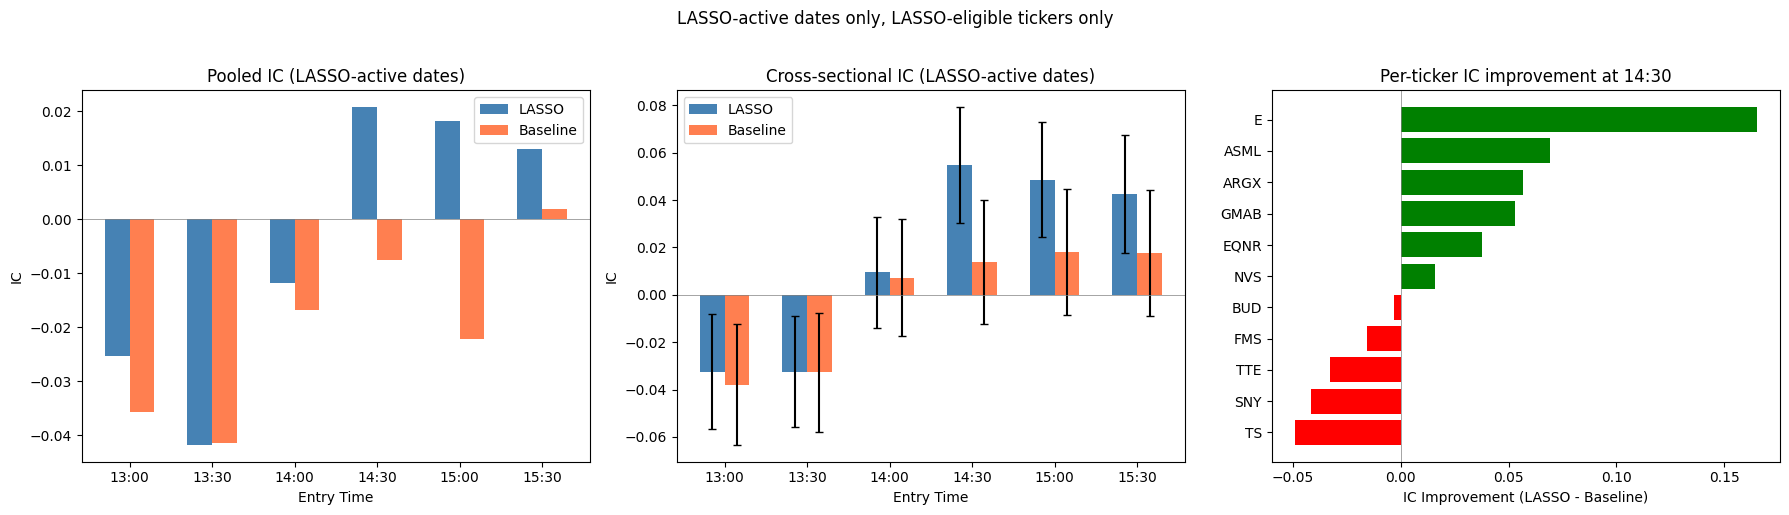

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Pooled IC
ax = axes[0]
x = range(len(ENTRY_TIMES))
ax.bar([i - 0.15 for i in x], lasso_pooled.values, 0.3, label='LASSO', color='steelblue')
ax.bar([i + 0.15 for i in x], base_pooled.values, 0.3, label='Baseline', color='coral')
ax.set_xticks(x)
ax.set_xticklabels(ENTRY_TIMES)
ax.set_xlabel('Entry Time')
ax.set_ylabel('IC')
ax.set_title('Pooled IC (LASSO-active dates)')
ax.legend()
ax.axhline(0, color='gray', linewidth=0.5)

# Plot 2: Cross-sectional IC
ax = axes[1]
ax.bar([i - 0.15 for i in x], lasso_cs.values, 0.3, label='LASSO', color='steelblue',
       yerr=lasso_cs_std.values, capsize=3)
ax.bar([i + 0.15 for i in x], base_cs.values, 0.3, label='Baseline', color='coral',
       yerr=base_cs_std.values, capsize=3)
ax.set_xticks(x)
ax.set_xticklabels(ENTRY_TIMES)
ax.set_xlabel('Entry Time')
ax.set_ylabel('IC')
ax.set_title('Cross-sectional IC (LASSO-active dates)')
ax.legend()
ax.axhline(0, color='gray', linewidth=0.5)

# Plot 3: Per-ticker IC improvement at 14:30
ax = axes[2]
eligible_improvement = per_ticker_comparison['Improvement'].sort_values()
colors = ['green' if v > 0 else 'red' for v in eligible_improvement.values]
ax.barh(range(len(eligible_improvement)), eligible_improvement.values, color=colors)
ax.set_yticks(range(len(eligible_improvement)))
ax.set_yticklabels(eligible_improvement.index)
ax.set_xlabel('IC Improvement (LASSO - Baseline)')
ax.set_title(f'Per-ticker IC improvement at {main_time}')
ax.axvline(0, color='gray', linewidth=0.5)

plt.suptitle('LASSO-active dates only, LASSO-eligible tickers only', y=1.02)
plt.tight_layout()
plt.show()